# 0. Imports

In [ ]:
!pip install torchviz
!pip install torchsummary
!pip install scikit-learn

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pandas as pd
import re
import torch
from tqdm import tqdm
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.tensorboard import SummaryWriter



# 1. Data Preprocessing

## Text file to CSV 

In [2]:
def process_file(file_path):
    clean_lines = []
    with open(file_path, 'r') as f:
        for line in f:
            clean_line = re.sub('\t', ' ', line.strip())
            clean_lines.append(clean_line)
    return clean_lines

def extract_info(clean_lines):
    protein_names = clean_lines[0::16]
    protein_strings = [re.sub(' ', '', line) for line in clean_lines[2::16]]
    
    acid_locations = []

     # Outer loop iterates over 'clean_lines' with a step of 16
    for i in range(0, len(clean_lines), 16):
        acid_location = []

        # Split the line into chunks of size 3
        line_parts = clean_lines[i + 13].split()
        
        for j in range(0, len(line_parts), 3):
            # Convert the next three items to float and append to 'acid_location'
            float_triplet = list(map(float, line_parts[j:j + 3]))
            acid_location.append(float_triplet)

        acid_locations.append(acid_location)

    return protein_names, protein_strings, acid_locations

file_path = "data"
clean_lines = process_file(file_path)
protein_names, protein_strings, acid_locations = extract_info(clean_lines)
    
data_dict = {
     'Protein Name': protein_names,
    'Protein String': protein_strings,
    'Acid Locations': acid_locations,
}
    
data = pd.DataFrame.from_dict(data_dict)
print(len(acid_locations), len(protein_names), len(protein_strings))

data.to_csv('/Users/oisinredmond/Final Year Project/proteins.csv')

15814 15814 15814


In [3]:
data['Protein Name'][51]

'4BVMA'

## Protein Strings Processing

In [4]:
# Define a mapping from amino acids to indices
amino_acids = 'ARNDCQEGHILKMFPSTWYV'
aa_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}

# Function to one-hot encode a protein string
def one_hot_encode(protein_string, max_length):
    tensor = torch.zeros(max_length, len(amino_acids))
    for i, aa in enumerate(protein_string):
        if aa in aa_to_index:
            tensor[i, aa_to_index[aa]] = 1
    return tensor

# Load the CSV file
data = pd.read_csv('/Users/oisinredmond/Final Year Project/proteins.csv')

# Calculate the lengths of the protein strings
string_lengths = data['Protein String'].str.len()

print("Longest string is: ", max(string_lengths))
plt.hist(string_lengths, bins='auto')
plt.title('Distribution of String Lengths')
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.show()

# Determine the 50th percentile length
cutoff_length = string_lengths.quantile(0.50)

# Filter out proteins longer than the 50th percentile
filtered_data = data[string_lengths <= cutoff_length]

# filtered_data = data[(string_lengths >= 200) & (string_lengths <= 300)]

# Find the maximum length after filtering
max_length = filtered_data['Protein String'].str.len().max()

# Convert each protein string to a one-hot encoded tensor with padding
one_hot_tensors = [one_hot_encode(seq, max_length) for seq in filtered_data['Protein String']]

# Stack tensors into a single tensor
string_tensor = torch.stack(one_hot_tensors)

print(string_tensor.shape)


Longest string is:  3323


torch.Size([7910, 191, 20])


In [5]:
sum(string_lengths)/len(string_lengths)

243.5911850259264

## Distance Data Generation

In [6]:
def string_to_float_tuples(s):
    # Remove the outer brackets and split the string into a list of strings, each representing a sub-list
    sub_lists = s.strip('[]').split('], [')
    
    # Convert each sub-list string into a tuple of floats
    float_tuples = [tuple(map(float, sub_list.split(', '))) for sub_list in sub_lists]
    
    return float_tuples

def calculate_pairwise_distances(matrix):
    diff = matrix.unsqueeze(0) - matrix.unsqueeze(1)
    distances = torch.sqrt((diff ** 2).sum(dim=-1))
    return distances

def calculate_distances(acid_locations):
    longest_acid = 191
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    relative_acid_distances = []
    original_sizes = []
    for loc in tqdm(acid_locations, desc="Calculating distances", unit="protein"):
        tensor_loc = torch.tensor(loc, dtype=torch.float32, device=device)
        distances = calculate_pairwise_distances(tensor_loc)
        original_sizes.append(distances.size(0))
        if distances.size(0) < longest_acid:
            padding = longest_acid - distances.size(0)
            distances= torch.nn.functional.pad(distances, (0, padding, 0, padding))
        distances = torch.tensor(np.triu(distances))
        relative_acid_distances.append(distances)
    
    return relative_acid_distances, original_sizes

filtered_acid_locations = list(map(string_to_float_tuples, filtered_data['Acid Locations']))
relative_acid_distances, original_sizes = calculate_distances(filtered_acid_locations)
distance_map_tensor = torch.stack(relative_acid_distances)

print(original_sizes)

og_sizes_tensor = torch.tensor(original_sizes)
distance_map_tensor[0]

Calculating distances: 100%|██████████| 7910/7910 [00:04<00:00, 1870.94protein/s]


[46, 83, 129, 82, 41, 52, 101, 172, 116, 64, 37, 67, 122, 93, 126, 184, 124, 105, 99, 58, 70, 81, 159, 88, 125, 166, 125, 55, 108, 74, 120, 133, 158, 115, 48, 122, 107, 122, 58, 62, 105, 145, 57, 109, 138, 119, 56, 68, 113, 67, 177, 182, 59, 182, 40, 36, 121, 35, 84, 137, 177, 77, 74, 161, 136, 120, 112, 121, 65, 99, 98, 176, 125, 82, 111, 94, 71, 114, 146, 117, 98, 167, 122, 111, 80, 166, 96, 118, 63, 34, 122, 106, 95, 56, 99, 100, 187, 59, 111, 190, 47, 153, 74, 119, 164, 86, 121, 59, 146, 153, 118, 98, 60, 122, 152, 135, 185, 132, 95, 90, 126, 40, 139, 61, 190, 73, 164, 131, 86, 114, 114, 97, 154, 87, 105, 62, 143, 94, 35, 61, 170, 36, 146, 154, 33, 176, 126, 144, 81, 134, 117, 64, 83, 79, 98, 63, 35, 127, 80, 161, 110, 116, 143, 159, 173, 100, 135, 171, 96, 87, 179, 141, 153, 73, 89, 141, 72, 141, 112, 127, 183, 115, 32, 111, 144, 185, 30, 97, 131, 150, 126, 84, 133, 86, 178, 117, 164, 155, 101, 108, 176, 131, 64, 166, 59, 186, 136, 150, 137, 144, 174, 158, 55, 96, 122, 187, 187, 1

tensor([[0.0000, 3.6851, 6.6678,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.7974,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

## Save

In [7]:
torch.save(distance_map_tensor, 'distance_map.pt')
torch.save(string_tensor, 'encoded_strings.pt')
torch.save(og_sizes_tensor, 'og_sizes.pt')


# 2. Data Analysis

## Distance Map Heatmap

In [8]:
plt.imshow(distance_map_tensor[51], cmap='viridis')
plt.colorbar()
plt.show()

## Entropy of Protein Strings

In [9]:
max_entropy = math.log2(20)
max_entropy

4.321928094887363

In [10]:
string_tensor = torch.load('encoded_strings.pt')

string_tensor[0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])

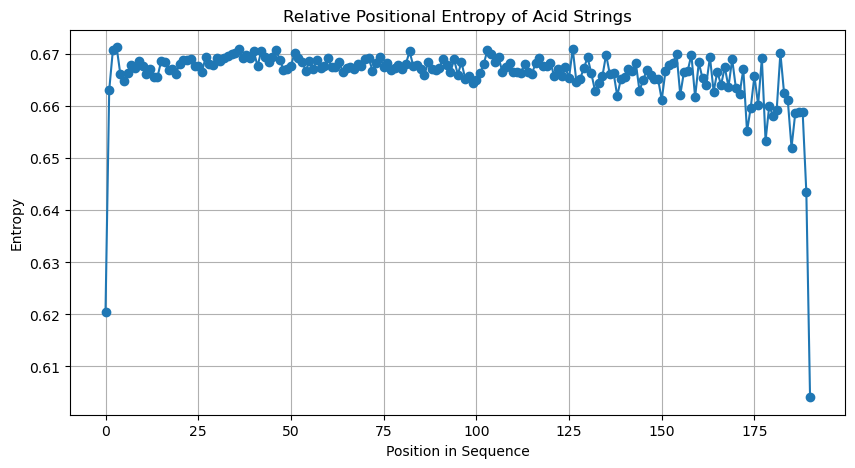

In [11]:
string_tensor = torch.load('encoded_strings.pt')

def calculate_entropy(one_hot_tensor):
    # Summing across the first dimension to get the frequency of each amino acid at each position
    freq_matrix = one_hot_tensor.sum(dim=0)

    # Normalizing frequencies to probabilities
    probabilities = freq_matrix / freq_matrix.sum(dim=1, keepdim=True)

    # Calculating entropy for each position
    log_probabilities = torch.log(probabilities)
    log_probabilities[probabilities == 0] = 0  # Handling log(0) by setting it to 0
    entropy = -torch.sum(probabilities * log_probabilities, dim=1)

    return entropy

max_entropy = math.log2(20)
string_entropy= calculate_entropy(string_tensor)
average_entropy = sum(string_entropy) / len(string_entropy)
relative_string_entropy = [e / max_entropy for e in string_entropy]

positions = range(0, len(string_entropy))
plt.figure(figsize=(10, 5))
plt.plot(positions, relative_string_entropy, marker='o')
plt.title("Relative Positional Entropy of Acid Strings")
plt.xlabel("Position in Sequence")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

torch.save(string_entropy, 'string_entropy.pt')


In [12]:
string_entropy.shape

torch.Size([191])

----------------

## Contact Map Creation

In [13]:
distance_maps= torch.load("distance_map.pt")

def contact_conversion(tensor, radius): 
    result_tensor = torch.where((tensor <= radius) & (tensor >= 0.01), torch.tensor(1.0), torch.tensor(0.0))
    return result_tensor
    
contact_maps = []

for i in range (6, 14, 2):
    print(i)
    contact_maps.append(contact_conversion(distance_maps, i))




6
8
10
12


In [14]:
sum(contact_maps[0][0][3])

tensor(6.)

In [15]:
contact_maps[0].shape

total_contacts = []
for i in range(0, 4):
    summed_elements = [tensor.sum(dim=1).tolist() for tensor in contact_maps[i]]
    total_contacts.append(summed_elements)

    
total_contacts = torch.tensor(total_contacts)
total_contacts.shape


torch.Size([4, 7910, 191])

In [16]:

torch.save(total_contacts, 'total_contacts.pt')

----------------------------------------------------------

## Histogram of Distances 

In [17]:
distance_maps = torch.load("distance_map.pt")
distances = distance_maps.flatten()
random_indices = torch.randperm(len(distances))[:100000]
random_sample = distances[random_indices]
print(sum(random_sample)/len(random_sample))
plt.hist(random_sample, range = (0.001, 100) , bins =200)
plt.xlabel('Distances')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

tensor(4.2491)


# 3. Prediction of Number of Contacts: Regression 

In [18]:
# GRU Model 

class AminoAcidContactPredictorGRU(nn.Module):
    def __init__(self, amino_acid_dim, hidden_dim, sequence_length):
        super(AminoAcidContactPredictorGRU, self).__init__()
        self.hidden_dim = hidden_dim

        # RNN layer for amino acid sequence
        self.rnn = nn.GRU(input_size=amino_acid_dim, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layer to predict the number of contacts per amino acid
        self.fc_out = nn.Linear(hidden_dim, sequence_length)

    def forward(self, amino_acid_seq):
        # RNN for amino acid sequence
        rnn_out, _ = self.rnn(amino_acid_seq)

        # Flatten the output for the fully connected layer
        rnn_out = torch.mean(rnn_out, dim=1)

        # Predict the number of contacts for each amino acid
        contacts_pred = self.fc_out(rnn_out)
        return contacts_pred

# Instantiate the model
amino_acid_dim = 20  # For one-hot encoded amino acids
hidden_dim = 128    
sequence_length = 191  

test_model = AminoAcidContactPredictorGRU(amino_acid_dim, hidden_dim, sequence_length)

string_tensor = torch.load('encoded_strings.pt')
total_contacts = torch.load('total_contacts.pt')

train_strings = string_tensor[0:4500]
train_contacts = total_contacts[0][0:4500]
predicted_total_contacts = test_model(train_strings[0:50])
print(predicted_total_contacts.shape)


torch.Size([50, 191])


In [ ]:
# Instantiate the model
amino_acid_dim = 20  # For one-hot encoded amino acids
hidden_dim = 128    
sequence_length = 191  

test_model = AminoAcidContactPredictorGRU(amino_acid_dim, hidden_dim, sequence_length)

writer = SummaryWriter()
writer.add_graph(test_model, input_to_model=torch.zeros([1, sequence_length, amino_acid_dim]))
writer.close()


In [ ]:
!tensorboard 


In [ ]:
class AminoAcidContactPredictorLSTM(nn.Module):
    def __init__(self, amino_acid_dim, hidden_dim, sequence_length):
        super(AminoAcidContactPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # RNN layer for amino acid sequence
        self.rnn = nn.LSTM(input_size=amino_acid_dim, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layer to predict the number of contacts per amino acid
        self.fc_out = nn.Linear(hidden_dim, sequence_length)

    def forward(self, amino_acid_seq):
        # RNN for amino acid sequence
        rnn_out, _ = self.rnn(amino_acid_seq)

        # Flatten the output for the fully connected layer
        rnn_out = torch.mean(rnn_out, dim=1)

        # Predict the number of contacts for each amino acid
        contacts_pred = self.fc_out(rnn_out)
        return contacts_pred

# Instantiate the model
amino_acid_dim = 20  # For one-hot encoded amino acids
hidden_dim = 128   
sequence_length = 191 

test_model = AminoAcidContactPredictorLSTM(amino_acid_dim, hidden_dim, sequence_length)

string_tensor = torch.load('encoded_strings.pt')
total_contacts = torch.load('total_contacts.pt')

train_strings = string_tensor[0:4500]
train_contacts = total_contacts[0][0:4500]
predicted_total_contacts = test_model(train_strings[0:50])
print(predicted_total_contacts.shape)


In [20]:
string_tensor = torch.load('encoded_strings.pt')
total_contacts = torch.load('total_contacts.pt')


# Choose, 0, 1, 2, 3 which represents 6A, 8A, 10Aand 12A
contact_radius = 3


train_strings = string_tensor[0:4500]
train_contacts = total_contacts[contact_radius][0:4500]

test_strings = string_tensor[4500:6000]
test_contacts = total_contacts[contact_radius][4500:6000]

val_strings = string_tensor[6000:]
val_contacts = total_contacts[contact_radius][6000:]


model = AminoAcidContactPredictorGRU(amino_acid_dim, hidden_dim, sequence_length)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

num_epochs = 50  # Set the number of epochs
batch_size = 32

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i in range(0, len(train_strings), batch_size):
        batch_strings = train_strings[i:i+batch_size]
        batch_contacts = train_contacts[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_strings)
        loss = loss_function(outputs, batch_contacts)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = running_loss / (len(train_strings) // batch_size)
    print(f'Epoch {epoch+1}, Training Loss: {average_loss}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_strings), batch_size):
            val_batch_strings = val_strings[i:i+batch_size]
            val_batch_contacts = val_contacts[i:i+batch_size]

            val_outputs = model(val_batch_strings)
            val_loss += loss_function(val_outputs, val_batch_contacts).item()

    average_val_loss = val_loss / (len(val_strings) // batch_size)
    print(f'Epoch {epoch+1}, Validation Loss: {average_val_loss}')

    # Early Stopping Check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered.")
            break
    

Epoch 1, Training Loss: 43.817446436200825
Epoch 1, Validation Loss: 29.126692658763822
Epoch 2, Training Loss: 30.78987133843558
Epoch 2, Validation Loss: 22.090540255530406
Epoch 3, Training Loss: 27.89127996989659
Epoch 3, Validation Loss: 21.18153336088536
Epoch 4, Training Loss: 27.62908774784633
Epoch 4, Validation Loss: 21.131536645404363
Epoch 5, Training Loss: 27.613300268990653
Epoch 5, Validation Loss: 21.117686336323366
Epoch 6, Training Loss: 27.542216614314487
Epoch 6, Validation Loss: 21.07450053651454
Epoch 7, Training Loss: 27.50284662246704
Epoch 7, Validation Loss: 20.98788613788152
Epoch 8, Training Loss: 27.462879957471575
Epoch 8, Validation Loss: 20.95298736378298
Epoch 9, Training Loss: 27.43140332358224
Epoch 9, Validation Loss: 20.96368143113993
Epoch 10, Training Loss: 27.40616979598999
Epoch 10, Validation Loss: 20.868489912000754
Epoch 11, Training Loss: 27.39118082863944
Epoch 11, Validation Loss: 20.8329826613604
Epoch 12, Training Loss: 27.34680682591029

In [23]:
def unpad_sequences(batch_data, original_lengths):
    unpadded_data = []
    for seq, length in zip(batch_data, original_lengths):
        unpadded_seq = seq[:length]  # Slice each sequence to its original length
        unpadded_data.append(unpadded_seq)
    return unpadded_data


original_lengths = torch.load('og_sizes.pt')[4500:6000]
test_outputs = []
test_targets = []

with torch.no_grad():
    for i in range(0, len(test_strings), batch_size):
        batch_strings = test_strings[i:i+batch_size]
        batch_contacts = test_contacts[i:i+batch_size]

        # Forward pass
        outputs = model(batch_strings)

        test_outputs.append(outputs)
        test_targets.append(batch_contacts)
        
unpadded_outputs = unpad_sequences(test_outputs, original_lengths)
unpadded_targets = unpad_sequences(test_targets, original_lengths)

# Concatenate all outputs and targets
test_outputs = torch.cat(unpadded_outputs, dim=0)
test_targets = torch.cat(unpadded_targets, dim=0)

# Convert to numpy arrays for evaluation
test_outputs_flat = test_outputs.view(-1).cpu().numpy()
test_targets_flat = test_targets.view(-1).cpu().numpy()

# Regression metrics
mse = mean_squared_error(test_targets_flat, test_outputs_flat)
mae = mean_absolute_error(test_targets_flat, test_outputs_flat)
r2 = r2_score(test_targets_flat, test_outputs_flat)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


MSE: 24.66288185119629
MAE: 3.4927561283111572
R²: 0.6068548287493023


# 4. Graphs

In [ ]:
total_contact = torch.load('total_contacts.pt')
flattened_contacts = total_contacts[0].flatten()
non_zero_contacts = flattened_contacts[flattened_contacts != 0]

plt.hist(non_zero_contacts, bins = 10)
plt.grid()
plt.title("Number of Residue Contacts for radius = 6Å")
plt.xlabel('Number of Contacts')
plt.ylabel('Number of Residues')
plt

In [ ]:
total_contact = torch.load('total_contacts.pt')
flattened_contacts = total_contacts[1].flatten()
non_zero_contacts = flattened_contacts[flattened_contacts != 0]

plt.hist(non_zero_contacts, bins = 5, density=True)
plt.grid()
plt.title("Number of Residue Contacts for radius = 8Å")
plt.xlabel('Number of Contacts')
plt.ylabel('Density')
plt

In [ ]:
total_contact = torch.load('total_contacts.pt')
flattened_contacts = total_contacts[2].flatten()
non_zero_contacts = flattened_contacts[flattened_contacts != 0]

plt.hist(non_zero_contacts, bins = 5, density=True)
plt.grid()
plt.title("Number of Residue Contacts for radius = 10Å")
plt.xlabel('Number of Contacts')
plt.ylabel('Density')
plt

In [ ]:
total_contact = torch.load('total_contacts.pt')
flattened_contacts = total_contacts[3].flatten()
non_zero_contacts = flattened_contacts[flattened_contacts != 0]

plt.hist(non_zero_contacts, bins = 20)
plt.grid()
plt.title("Number of Residue Contacts for radius = 12Å")
plt.xlabel('Number of Contacts')
plt.ylabel('Number of Residues')
plt

In [ ]:
total_contacts[3][0]

In [ ]:
distance_maps = torch.load('distance_map.pt')
distance_maps[0][0]

In [ ]:
total_contacts = torch.load('total_contacts.pt')
flattened_contacts = total_contacts[3].flatten()
non_zero_contacts = flattened_contacts[flattened_contacts != 0]
average = sum(non_zero_contacts)/len(non_zero_contacts)
4.1596/average.item()

## Results Graphs

In [ ]:

# Data
epochs = list(range(1, 11))
training_loss = [47.89721121106829, 40.7655137198312, 40.77566024235317, 40.77983469281878, 
                 41.488818877083915, 40.627807412828716, 40.500267478397916, 40.46419427054269, 
                 40.49225484303066, 40.39097709655762]
validation_loss = [35.81746702679133, 35.640175092018254, 35.53875994278213, 35.445961192502814, 
                   35.15026218608274, 34.74538185636876, 34.65105987807452, 34.53725326667398, 
                   34.311676995228915, 34.903922420437056]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch on Radius 12Å')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Data 
training_loss = [1.677577701636723, 1.2729219266346523, 1.2449437183993204, 1.1554889406476703, 
                   1.1228873469999858, 1.0960973577839987, 1.0785810943160739, 1.0671312187399182, 
                   1.0600706096206391, 1.04805859710489]
validation_loss = [1.1267471990342868, 1.1071959289453797, 0.9666046358771243, 0.9416942353975974, 
                     0.8782799183312109, 0.8627682803040844, 0.8483776773436594, 0.844635033001334, 
                     0.8397724588038558, 0.8482343847468748]

# Creating the plot for the second model
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch on Radius 6Å')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Data for the third model
training_loss = [17.72850705555507, 14.535497624533518, 12.639410775048391, 11.567777715410505, 
                   11.133759539467947, 10.960831560407366, 10.892927517209735, 10.88561553955078, 
                   10.848079913003104, 10.826301574707031]
validation_loss = [13.31426583306264, 11.229742745221671, 9.544749914589575, 8.931466692585056, 
                     8.651113784919351, 8.569806236331745, 8.53726545430846, 8.519746198492536, 
                     8.490164368839586, 8.480194495896162]

# Creating the plot for the third model
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch on Radis 10Å')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Data for the fourth model
training_loss = [5.412188625335693, 3.810748268876757, 3.4943613750594005, 3.489373731613159, 
                   3.484729698726109, 3.4730888792446684, 3.4513840130397253, 3.4244156462805613, 
                   3.397978438649859, 3.347240560395377]
validation_loss = [4.0195578356920665, 2.84373399766825, 2.831177602380009, 2.817414780794564, 
                     2.8064572568667137, 2.7818599555451993, 2.832243810265751, 2.759194992356381, 
                     2.70389585575815, 2.5530563916190196]

# Creating the plot for the fourth model
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch on Radius 8Å')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
epochs = list(range(1, 14))

training_loss = [
    33.9969705581665, 28.825081171308245, 28.763427352905275, 28.529307855878557,
    28.377573449271065, 28.0528530393328, 28.152600601741245, 28.043177127838135,
    28.18212171282087, 27.89010727746146, 27.845822361537387, 28.57460844857352,
    31.761552483694896
]
validation_loss = [
    23.64655876159668, 23.396623805417853, 22.813478081913317, 23.304443165407342,
    22.524145158670716, 22.95203409356586, 22.230659549519167, 22.62354058734441,
    22.733510841757564, 22.135443251011736, 22.8577176756778, 25.863997378591765,
    28.71511271848517
]

# Creating the plot for the fourth model
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch on Radius 12Å with LR = 0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()